In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

In [2]:
# 5. 잔액정보
features_balance = [
    '잔액_일시불_B0M', '잔액_할부_B0M',
    '연체잔액_B0M',
    '연체원금_최근', '매각잔액_B1M',
    'RV_평균잔액_R3M',
    '연체잔액_RV일시불_B0M', '연체잔액_CA_B0M',
    '평잔_일시불_3M',
    '평잔_6M', '평잔_카드론_3M', '평잔_CA_3M'
]

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import os
# 1. 데이터 불러오기
df = pd.read_parquet("C:/Users/KING/Desktop/workspace/11_파이널프로젝트관련/팀 파일/data/통합_train_데이터.parquet")

# 2. 피처 및 타겟 분리
X = df[features_balance].copy()
y = df["Segment"]

# 3. 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 결측치 처리
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 5. 스케일링 (DataFrame 형태 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 6. 라벨 인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 7. train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 8. XGBoost 모델 선언 (GPU 가속)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 9. 학습
xgb_model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = xgb_model.predict(X_val)

# F1-micro score 계산
from sklearn.metrics import f1_score
# F1-micro score 출력
f1_micro = f1_score(y_val, y_pred, average='micro')
print("📌 F1-micro score:", round(f1_micro, 4))

# 전체 분류 리포트 출력
print("\n📋 Classification Report:")
print(classification_report(y_val, y_pred, target_names=le_y.classes_))

              precision    recall  f1-score   support

           0       0.71      0.03      0.05       194
           1       0.00      0.00      0.00        29
           2       0.61      0.36      0.45     25518
           3       0.52      0.33      0.40     69848
           4       0.88      0.96      0.92    384411

    accuracy                           0.84    480000
   macro avg       0.54      0.34      0.36    480000
weighted avg       0.81      0.84      0.82    480000



 99%|===================| 1492/1500 [00:45<00:00]        

🔍 SHAP beeswarm plot for Segment A


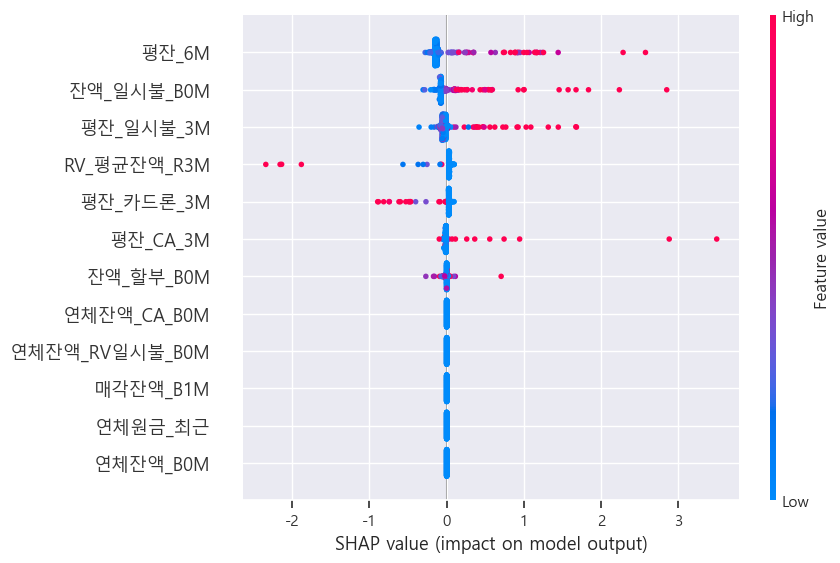

🔍 SHAP beeswarm plot for Segment B


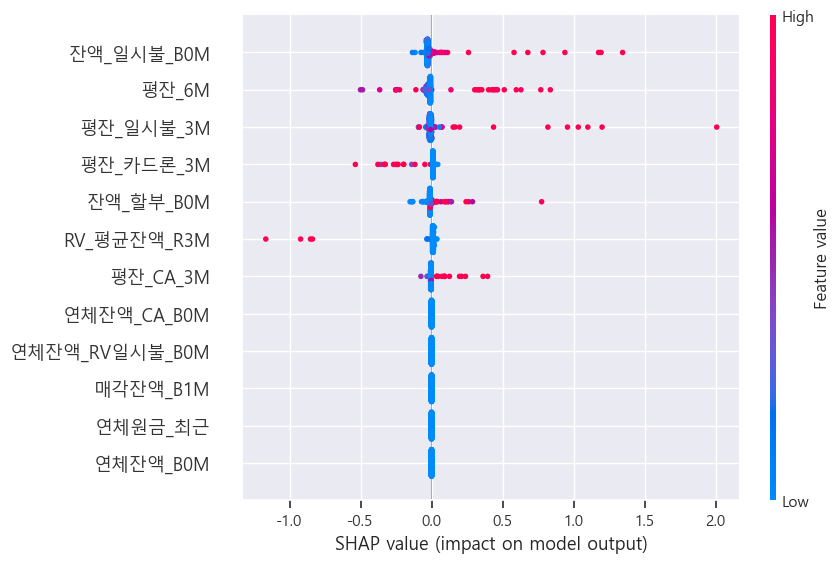

🔍 SHAP beeswarm plot for Segment C


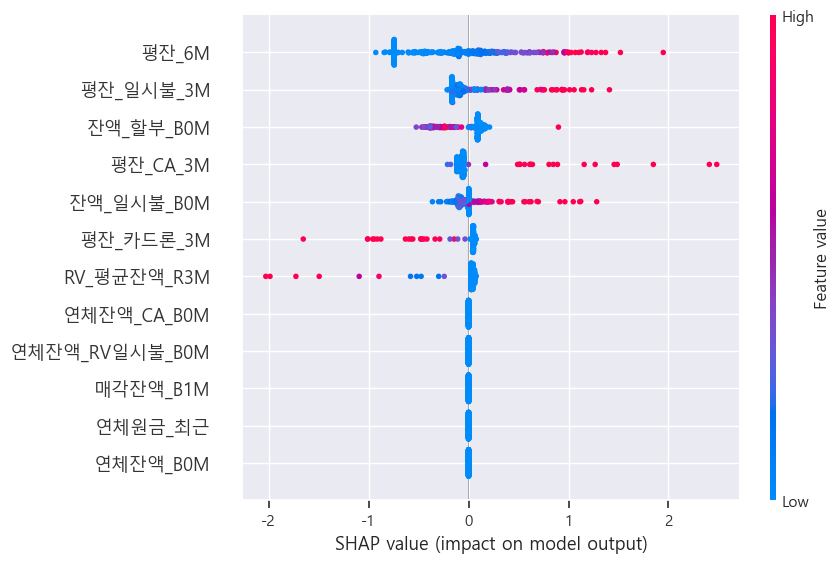

🔍 SHAP beeswarm plot for Segment D


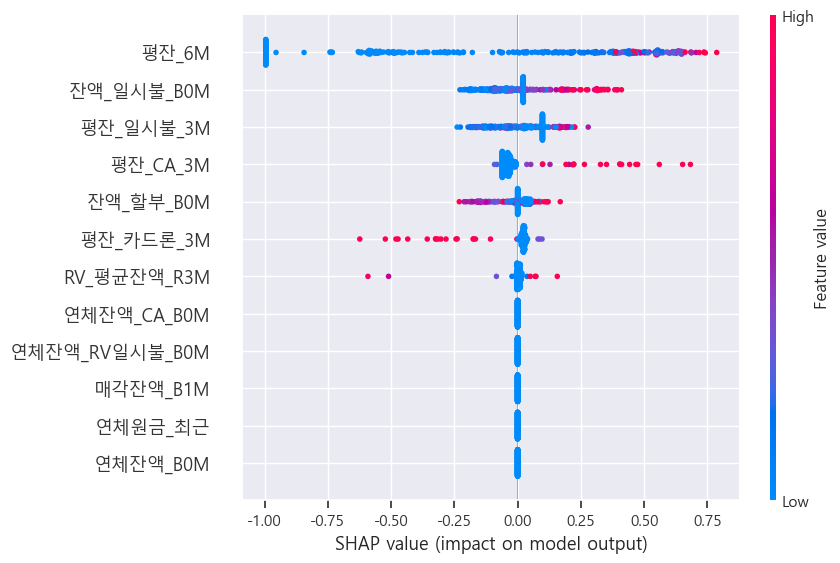

🔍 SHAP beeswarm plot for Segment E


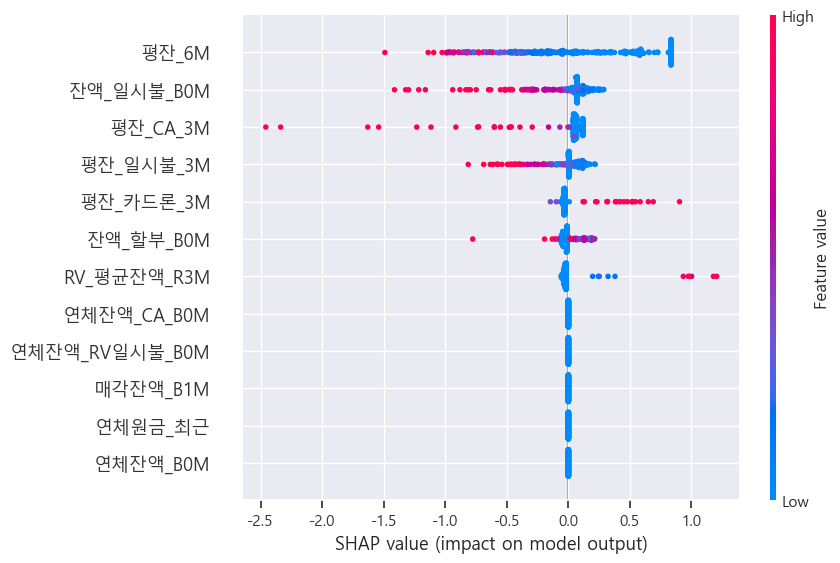

In [4]:
import shap  
import pandas as pd

# 1. 피처 이름 있는 DataFrame 준비
X_val_df = pd.DataFrame(X_val, columns=features_balance)

# 2. 전체 샘플에서 300개만 샘플링 (속도 문제 방지)
X_sample = X_val_df.sample(n=min(300, len(X_val_df)), random_state=42)

# 3. SHAP Explainer 생성 및 계산
explainer = shap.Explainer(xgb_model, X_sample)
shap_values = explainer(X_sample)

# 4. Segment 0~4 각각에 대해 beeswarm plot 출력
for i, class_label in enumerate(['A', 'B', 'C', 'D', 'E']):
    print(f"🔍 SHAP beeswarm plot for Segment {class_label}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)


<Figure size 1000x600 with 0 Axes>

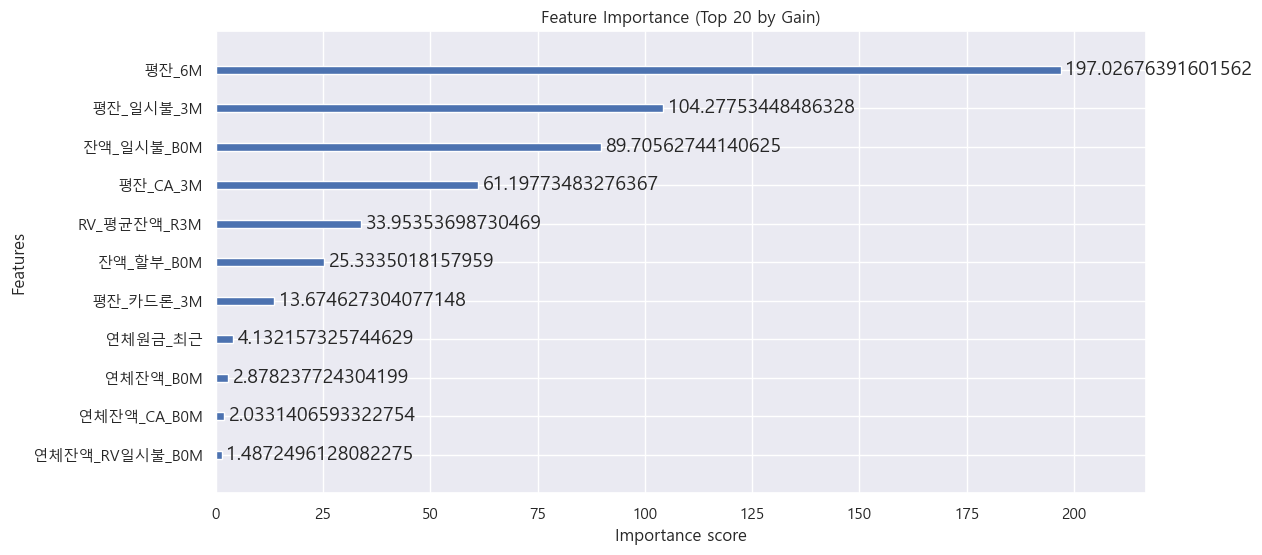

In [5]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title("Feature Importance (Top 20 by Gain)")
plt.show()
